In [1]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, AncillaRegister, Parameter
from qiskit.quantum_info import Statevector, Operator

import numpy as np
import PuzzleConfigurations as pc

# Summary of the algorithm:

Step 1: input a $2^2\times 2^2$ Sudoku board

Step 2: prepare input for quantum circuit initialization:
    - Find all possible configurations for each row, each column, and each $2\times 2$-quadrant of the given board. If a row/column/quadrant trivially only has one possible configuration, we immediately fill the unknows with that configuration. 
    - The number of rows + columns + quadrants is $4+4+4=12$. This is the maximal number of constraints we will have. In practice, not all will be present. Each row/column/quadrant has to take on one of the possible configurations we have found in the previous step. 

Steo 3: Initialize qubits:
    - If $n$ is the number of unknowns left, then we need $n\times 2$ qubits to represent the unkowns. We initialize them as $H\ket{00}$.
    - For each constraint, we will need one ancillar qubit, which tells us if that constraint is satisfied or not.

Step 4: #todo




We begin by inputting the entries of a $2^2\times 2^2$ Sudoku game. Our convention will be to indicate unknown values by $0.$ All other values must be 1, 2, 3, 4.

Now we will find all configurations for rows/columns/quadrants and complete the values which can be trivially filled. Then we will convert the board into row/column/square constraints.

In [2]:
puzzle = [
        [0, 0, 2, 3],
        [0, 2, 0, 4],
        [0, 1, 3, 0],
        [0, 0, 4, 1]
    ] 

print("Started with the following puzzle:")
for row in puzzle:
    print(row)
print()

pc.complete_all_trivial_missing_values(puzzle)

print("Completed trivial missing values. Current puzzle:")
for row in puzzle:
    print(row)
print()

# count remaining unknowns
number_of_unknowns = 0
for row in puzzle:
    number_of_unknowns += row.count(0)

print("Number of remaining unknowns:", number_of_unknowns)


constraints = pc.row_possible_values(puzzle) + pc.column_possible_values(puzzle) + pc.square_possible_values(puzzle)
constraints = [constraint for constraint in constraints if constraint[0] != [] ]
number_of_constraints = len(constraints)

print("Number of remaining constraints:", number_of_constraints)

Started with the following puzzle:
[0, 0, 2, 3]
[0, 2, 0, 4]
[0, 1, 3, 0]
[0, 0, 4, 1]

Completed trivial missing values. Current puzzle:
[0, 0, 2, 3]
[3, 2, 1, 4]
[4, 1, 3, 2]
[0, 0, 4, 1]

Number of remaining unknowns: 4
Number of remaining constraints: 6


In [3]:
[[x[0], list(x[1])] for x in constraints]

[[[(0, 0), (0, 1)], [(1, 4), (4, 1)]],
 [[(3, 0), (3, 1)], [(2, 3), (3, 2)]],
 [[(0, 0), (3, 0)], [(1, 2), (2, 1)]],
 [[(0, 1), (3, 1)], [(3, 4), (4, 3)]],
 [[(0, 0), (0, 1)], [(1, 4), (4, 1)]],
 [[(3, 0), (3, 1)], [(2, 3), (3, 2)]]]

Our next step is to initiate our qubits and a circuit. Let $n$ be the number of unknowns on the board after completing obvous unknowns. To represent the four numbers 1, 2, 3, 4 we will need 2 bits. Each bit we can then represent via a quibit in the obvious way: $0\mapsto \ket{0}$ and $1\mapsto \ket{1}$. Thus we need two qubits to represent the four numbers 1, 2, 3, 4 via qubits. Hence, we initiate $n\times 2$ qubits for the unknowns. 

Notation: We will use the number $0$ to represent an unknown on the board. To save space, we will then represent the numbers 1, 2, 3, 4 as follows via bits: $$1\mapsto 00,$$
$$2\mapsto 01,$$
$$3\mapsto 10,$$ 
$$4\mapsto 11.$$

Notation: Let $i$ be an integer from $0$ to $n-1$. We denote by u_i the qubit corresponding to the zeroth bit of the $i$-th unknown and by t_i the first bit of the $i$-th unknown. For example, if the $7$-th unknown ends up being 3, we represent it with the bits $10$ and thus u_7=0 and t_7=1.

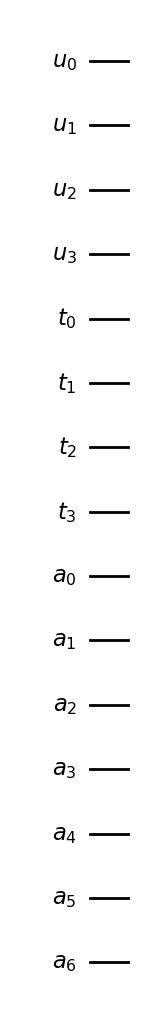

In [4]:
quantum_register_u = QuantumRegister(size=number_of_unknowns, name="u") #first bit of each unknown
quantum_register_t = QuantumRegister(size=number_of_unknowns, name="t") #second bit of each unknown
ancilla_register = AncillaRegister(size=number_of_constraints + 1, name="a") #ancilla bits for the sudoku constraints

quantum_circuit = QuantumCircuit(quantum_register_u, quantum_register_t, ancilla_register, name="sudoqu") 


# draw the initial circuit
quantum_circuit.draw(output="mpl", style="bw")


Let us define more helpful variables.

In [5]:

#create a dictionary to map numbers to bit values as described above. We use the [u, t] ordering.
number_to_bit = {
    1: [0, 0],
    2: [1, 0],
    3: [0, 1],
    4: [1, 1]
}

#create a dictionary to map cell positions to 2-qubit indices
c_to_q = {}
for row in range(len(puzzle)):
    for col in range(len(puzzle[row])): 
        if puzzle[row][col] == 0:
            c_to_q[(row, col)] = len(c_to_q)

#create a two-bit equality checker xor-gate: first two qubits are the two-bit number to be checked, the last is the zero ancilla. The bits come out to be 1 if they match.
number_checker = {}
for i in number_to_bit:
    number_checker[i] = QuantumCircuit(3)
    for j in range(2):
        if number_to_bit[i][j] == 1:
            number_checker[i].x(j)
        number_checker[i].cx(2, j)
        number_checker[i].x(j)
    number_checker[i] = number_checker[i].to_gate()


We will now need to add gates to check if the given qubits satisfy valid configurations for each row/column/quadrant. We store such validness result on he ancilla qubits, starting from index 1. We transform any qubits coinciding with a valid configuration into 1, then flip the corresponding ancilla if all bits are correct, using a multi-controlled X gate. We need to take care to then uncompute such transformations on non-ancillas.

In [6]:
#start checking constraints

for const_idx in range(len(constraints)):
    constraint = constraints[const_idx]
    indices = [c_to_q[coord] for coord in constraint[0]]
    for permutation in constraint[1]:
        for i in range(len(indices)):
            qubit_idx = indices[i]
            quantum_circuit.compose(number_checker[permutation[i]], qubits = [quantum_register_u[qubit_idx], quantum_register_t[qubit_idx], ancilla_register[0]], inplace = True)
        quantum_circuit.mcx([quantum_register_u[qubit_idx] for qubit_idx in indices]+[quantum_register_t[qubit_idx] for qubit_idx in indices], ancilla_register[const_idx + 1])
        for i in range(len(indices)):
            qubit_idx = indices[i]
            quantum_circuit.compose(number_checker[permutation[i]].inverse(), qubits = [quantum_register_u[qubit_idx], quantum_register_t[qubit_idx], ancilla_register[0]], inplace = True)



Let us store the half-marker thus constructed (i.e. before multi-controlled Z puts a minus sign on the sought after configuration) as a gate.

In [7]:
half_marker = quantum_circuit.to_gate()

We now complete the rest of the marker circuit and save it as a gate.

In [8]:
quantum_circuit.mcp(np.pi, ancilla_register[1:-1], ancilla_register[-1])
quantum_circuit.compose(half_marker.inverse(),qubits = quantum_register_u[:] + quantum_register_t[:] + ancilla_register[:], inplace=True)

In [9]:
marker_circuit = quantum_circuit.to_gate()

In [10]:
n = 2*number_of_unknowns
N = 2**n
K = int(np.rint(np.pi / (4 * np.arcsin(1 / np.sqrt(N))) - 1/2))


grover_circuit = QuantumCircuit(quantum_register_u,quantum_register_t, ancilla_register, name="Grover circuit")


grover_circuit.h(range(n))
for idx in range(K):
    grover_circuit.compose(marker_circuit, qubits = quantum_register_u[:] + quantum_register_t[:] + ancilla_register[:], inplace = True)
    grover_circuit.h(range(n))
    grover_circuit.x(range(n))
    grover_circuit.mcp(np.pi, quantum_register_u[:] + quantum_register_t[:-1], quantum_register_t[-1])
    grover_circuit.x(range(n))
    grover_circuit.h(range(n))

psi = Statevector(grover_circuit)
prob_dict = psi.probabilities_dict()
max_key = max(prob_dict, key=prob_dict.get)
for row, col in c_to_q:
    idx = c_to_q[(row, col)]
    puzzle[row][col] = 1+int(max_key[-1-idx])+2*int(max_key[-number_of_unknowns -1-idx])

print("Highest probability solution:")
for row in puzzle:
    print(row)
print()

Highest probability solution:
[1, 3, 2, 3]
[3, 2, 1, 4]
[4, 1, 3, 2]
[3, 4, 4, 1]

